# Padded SGM: Proof of Effectiveness
> Simulated data experiments showing effectiveness of SGM implementation

- toc: false 
- badges: true
- comments: true
- categories: [graph-matching, ali-s-e]
- hide: false
- search_exclude: false

In [1]:
# collapse
import sys
sys.path
sys.path.insert(0, '/Users/asaadeldin/Downloads/GitHub/scipy')
from scipy.optimize import quadratic_assignment


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Fig3 from SGM paper

![title](images/sgm_fig3_2.png)

In [6]:
# collapse
# simulating G1', G2, deleting 25 vertices
from graspy.simulations import sbm_corr
from graspy.plot import heatmap
directed = False
loops = False
block_probs = [[0.9,0.4,0.3,0.2],
                [0.4,0.9,0.4,0.3],
                [0.3,0.4,0.9,0.4],
                [0.2,0.3,0.4,0.7]]
n =100
n_blocks = 4
rho = 0.5
block_members = np.array(n_blocks * [n])
n_verts = block_members.sum()
G1p, G2 = sbm_corr(block_members,block_probs, rho, directed, loops)
G1 = np.zeros((300,300))
c = np.copy(G1p)
keep = [np.random.randint(100*i, 100*(i+1)-1, 75) for i in range(4)]
delete = [np.setdiff1d(np.arange(100*i, 100*(i+1)-1), keep[i]) for i in range(4)]

for i in range(5):
    stepx = 100*i
    c[75+stepx:stepx+100,:] = -1
    c[:, 75+stepx:stepx+100] = -1
    for j in range(5):
        stepy = 100*j
        G1[(75*i):(75*(i+1)),(75*j):(75*(j+1))] = G1p[stepx:(stepx+75),stepy:(stepy+75)]

In [7]:
# hide
# for i in range(4):
#     stepx = 100*i
#     c[75+stepx:stepx+100,:] = -1
#     c[:, 75+stepx:stepx+100] = -1
#     for j in range(4):
#         stepy = 100*j
#         G1[(75*i):(75*(i+1)),(75*j):(75*(j+1))] = G1p[keep[i],keep[j]]
        

<AxesSubplot:title={'center':'Graph 1'}>

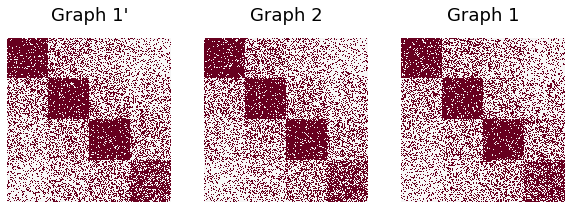

In [8]:
# hide
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
heatmap(G1p, ax=axs[0], cbar=False, title="Graph 1'")
heatmap(G2, ax=axs[1], cbar=False, title="Graph 2")
heatmap(G1, ax=axs[2], cbar=False, title="Graph 1")


In [9]:
def naive_pad(A,B):
    def pad(X, n):
        A_pad = np.zeros((n[1],n[1]))
        A_pad[:n[0],:n[0]] = X
        return A_pad
    n = np.sort([A.shape[0], B.shape[0]])
    if A.shape[0] == n[0]:
        A = pad(A, n)
    else:
        B = pad(B, n)
        
    return A, B
    

In [10]:
# collapse
gn1, gn2 = naive_pad(G1,G2)
seed1 = np.random.randint(0,300,10)
seed2 = [int(x/75)*25 + x for x in seed1]
pm = np.asarray([seed2, seed1]).T
gmp = {'maximize': True, 'partial_match': pm, 'shuffle_input': True}
res = quadratic_assignment(gn2, gn1, options=gmp)
perm = res.col_ind
gn1ps = gn1[perm][:,perm]
gmp = {'maximize': True, 'shuffle_input': True}
res = quadratic_assignment(gn2, gn1, options=gmp)
perm = res.col_ind
gn1p = gn1[perm][:,perm]


<AxesSubplot:title={'center':'Naive Padding, 10 seeds'}>

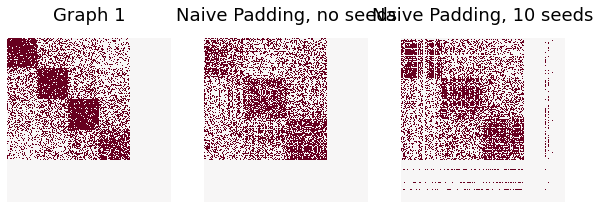

In [11]:
# hide
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
plt.title('Naive Padding')
heatmap(gn1, ax=axs[0], cbar=False, title="Graph 1")
heatmap(gn1p, ax=axs[1], cbar=False, title="Naive Padding, no seeds")
heatmap(gn1ps, ax=axs[2], cbar=False, title="Naive Padding, 10 seeds")

In [12]:
def adopted_pad(A,B):
    def pad(X, n):
        X_pad = np.zeros((n[1],n[1]))
        X_pad[:n[0],:n[0]] = X
        return X_pad
    A_n = A.shape[0]
    B_n = B.shape[0]
    n = np.sort([A_n, B_n])
    A_til = 2*A - np.ones((A_n, A_n))
    B_til = 2*B - np.ones((B_n, B_n))
    if A_n == n[0]:
        A_til = pad(A_til, n)
    else:
        B_til = pad(B_til, n)
    return A_til, B_til

In [16]:
# collapse
ga1, ga2 = adopted_pad(G1,G2)
seed1 = np.random.randint(0,300,10)
seed2 = [int(x/75)*25 + x for x in seed1]
pm = np.asarray([seed2, seed1]).T
gmp = {'maximize': True, 'partial_match': pm, 'shuffle_input': True}
res = quadratic_assignment(ga2, ga1, options=gmp)
print(res.fun)
perm = res.col_ind
ga1p = gn1[perm][:,perm]



55596.0


<AxesSubplot:title={'center':'Graph 1 AP'}>

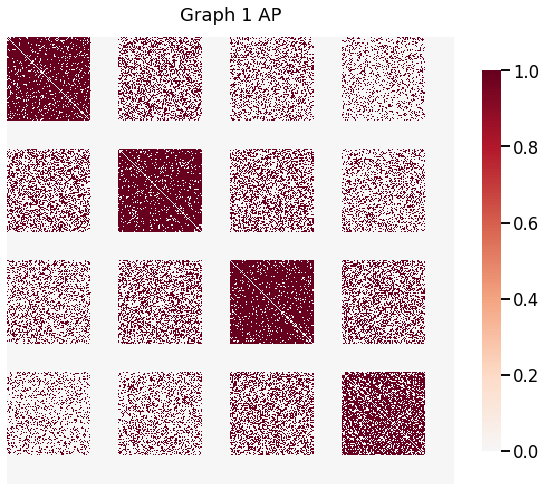

In [17]:
# hide
heatmap(ga1p, cbar=True, title="Graph 1 AP")

# Recreate Fig3

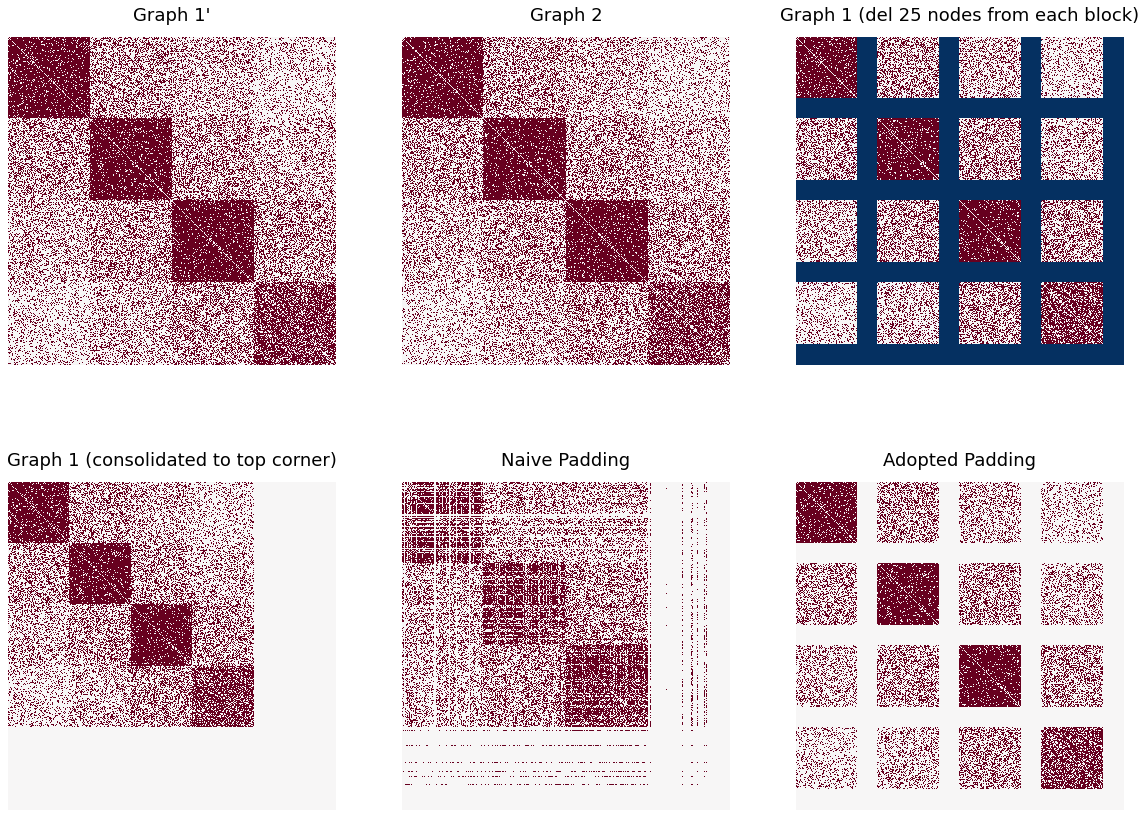

In [19]:
# hide
fig, axs = plt.subplots(2, 3, figsize=(20, 15))
heatmap(G1p, ax=axs[0,0], cbar=False, title="Graph 1'")
heatmap(G2, ax=axs[0,1], cbar=False, title="Graph 2")
heatmap(c, ax=axs[0,2], cbar=False, title="Graph 1 (del 25 nodes from each block)")
heatmap(gn1, ax=axs[1,0], cbar=False, title="Graph 1 (consolidated to top corner)")
heatmap(gn1ps, ax=axs[1,1], cbar=False, title="Naive Padding")
heatmap(ga1p, ax=axs[1,2], cbar=False, title="Adopted Padding")
plt.savefig('rec_psgm_f3.png')

![title](images/rec_psgm_f3.png)